In [26]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader,ConcatDataset
from torchvision import transforms
import os
import torch.nn as nn

In [63]:
pacs_dataset_hf = load_dataset("flwrlabs/pacs", split='train')

In [64]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [65]:
source_domains = ['art_painting', 'cartoon', 'photo']
target_domain = 'sketch'

datasets_by_domain = {}
for domain_name in source_domains + [target_domain]:
    filtered_dataset = pacs_dataset_hf.filter(lambda example: example['domain'] == domain_name)
    datasets_by_domain[domain_name] = filtered_dataset
    print(f"  - Found {len(filtered_dataset)} images for domain: {domain_name}")

  - Found 2048 images for domain: art_painting
  - Found 2344 images for domain: cartoon
  - Found 1670 images for domain: photo
  - Found 3929 images for domain: sketch


In [66]:
def apply_transforms(batch, transform_pipeline):
    batch['pixel_values'] = [transform_pipeline(image.convert("RGB")) for image in batch['image']]
    del batch['image']
    return batch

for domain_name, dataset in datasets_by_domain.items():
    if domain_name in source_domains:
        # Source domains are for training, so they get the train_transform
        print(f"Applying AUGMENTED transforms to source domain: {domain_name}")
        transform_to_apply = train_transform
    else:
        # The target domain is for evaluation, so it gets the eval_transform
        print(f"Applying DETERMINISTIC transforms to target domain: {domain_name}")
        transform_to_apply = eval_transform
    
    # We use a lambda function here to pass the correct transform into our apply_transforms function
    dataset.set_transform(lambda batch: apply_transforms(batch, transform_to_apply))

Applying AUGMENTED transforms to source domain: art_painting
Applying AUGMENTED transforms to source domain: cartoon
Applying AUGMENTED transforms to source domain: photo
Applying DETERMINISTIC transforms to target domain: sketch


In [67]:
source_datasets_list = [datasets_by_domain[name] for name in source_domains]
train_dataset_erm = ConcatDataset(source_datasets_list)
target_dataset_erm = datasets_by_domain[target_domain]

In [68]:
train_loader_erm = DataLoader(train_dataset_erm, batch_size=32, shuffle=True)
test_loader = DataLoader(datasets_by_domain[target_domain], batch_size=32, shuffle=False)

In [33]:
class Patchembedding(nn.Module):
    def __init__(self, img_size = 224, patch_size = 16, in_chan = 3, emb_dim = 768):
        super().__init__()
        self.n_patches = (img_size//patch_size) ** 2
        self.proj = nn.Conv2d(in_chan,emb_dim,kernel_size=patch_size,stride = patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.n_patches + 1, emb_dim))
    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        return x


In [34]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=768, n_heads=12, dropout=0.0):
        super().__init__()
        self.n_heads = n_heads
        self.head_dim = embed_dim // n_heads
        self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)

    def forward(self, x):
        B, N, D = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.n_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, N, D)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [35]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x); x = self.act(x); x = self.drop(x)
        x = self.fc2(x); x = self.drop(x)
        return x

In [36]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim=768, n_heads=12, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, n_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = MLP(embed_dim, mlp_hidden_dim, embed_dim, dropout)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


In [37]:
class VisionTransformer(nn.Module):
   
    def __init__(self, img_size=224, patch_size=16, in_channels=3, n_classes=7, 
                 embed_dim=768, depth=12, n_heads=12, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        self.patch_embed = Patchembedding(img_size, patch_size, in_channels, embed_dim)
        
        self.encoder_blocks = nn.Sequential(*[
            TransformerEncoderBlock(embed_dim, n_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.encoder_blocks(x)
        cls_token_final_embedding = self.norm(x[:, 0])
        logits = self.head(cls_token_final_embedding)
        
        return logits

In [38]:
# checkpoints = [5,8,10,14]
# device = "cuda" if torch.cuda.is_available() else "cpu"
# N_CLASSES = 7
# model = VisionTransformer(n_classes=N_CLASSES).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# epochs = 15
# losses = []
# for i in range(epochs):
#     epoch_loss = 0
#     for j,batch in enumerate(train_loader_erm):
#         images = batch['pixel_values'].to(device)
#         labels = batch['label'].to(device)
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         epoch_loss = epoch_loss + loss.item()
#         if j % 30 == 0:
#             print(f"                epoch {i} for batch {j}/{len(train_loader_erm)}: {loss.item()}")
#     epoch_loss = epoch_loss / len(train_loader_erm)
#     losses.append(epoch_loss)
#     print(f"loss in epoch {i} is: {epoch_loss}")
#     if i in checkpoints:
#         os.makedirs("erm_checkpoints", exist_ok=True)
#         torch.save(model.state_dict(), f"erm_checkpoints/erm_model{i}.pth")


In [39]:
# epochs = ["5","8","10","14"]
# for i in epochs:
#     device = "cuda"
#     irm_model = VisionTransformer(n_classes=7)
#     state_dict = torch.load(f"erm_checkpoints/erm_model{i}.pth", map_location="cpu")
#     irm_model.load_state_dict(state_dict)
#     irm_model.to(device)
#     target_total = 0
#     target_correct = 0
#     predicted_correct = 0
#     predicted_total = 0
#     epoch_loss = 0
#     irm_model.eval()
#     criterion = nn.CrossEntropyLoss()
#     for j,batch in enumerate(test_loader):
#         with torch.no_grad():
#             images = batch['pixel_values'].to(device)
#             labels = batch['label'].to(device)
#             outputs = irm_model(images)
#             loss = criterion(outputs, labels)
#             epoch_loss = epoch_loss + loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             target_total += labels.size(0)
#             target_correct += (predicted == labels).sum().item()
#     epoch_loss = epoch_loss / len(test_loader)
#     print(f"model {i} target_loss: {epoch_loss}")
#     print(f"model {i} target_acc: {target_correct/target_total}")
#     epoch_loss = 0
#     for j,batch in enumerate(train_loader_erm):
#         with torch.no_grad():
#             images = batch['pixel_values'].to(device)
#             labels = batch['label'].to(device)
#             outputs = irm_model(images)
#             loss = criterion(outputs, labels)
#             epoch_loss = epoch_loss + loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             predicted_total += labels.size(0)
#             predicted_correct += (predicted == labels).sum().item()
            
#     epoch_loss = epoch_loss / len(train_loader_erm)
#     print(f"model {i} source_loss: {epoch_loss}")
#     print(f"model {i} source_acc: {predicted_correct/predicted_total}")



In [40]:
import torchvision.models as models
checkpoints = [0,1,2,3,4]
device = "cuda" if torch.cuda.is_available() else "cpu"
N_CLASSES = 7

# --- THE ONLY CHANGE: Use a pre-trained ResNet-50 instead of your ViT ---
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
# Replace the final layer for the PACS task (7 classes)
model.fc = nn.Linear(num_ftrs, N_CLASSES)
model.to(device)
# --- End of Change ---

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # This will now fine-tune all parameters
epochs = 5
losses = []

print("Starting fine-tuning...")
for i in range(epochs):
    epoch_loss = 0
    model.train() # Set model to training mode
    for j, batch in enumerate(train_loader_erm):
        images = batch['pixel_values'].to(device)
        labels = batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if j % 30 == 0:
            print(f"                epoch {i} for batch {j}/{len(train_loader_erm)}: {loss.item()}")
            
    epoch_loss = epoch_loss / len(train_loader_erm)
    losses.append(epoch_loss)
    print(f"loss in epoch {i} is: {epoch_loss}")

    # Your original checkpointing logic (suboptimal, but unchanged as requested)
    if i in checkpoints:
        print(f"Saving checkpoint at epoch {i}...")
        os.makedirs("erm_checkpoints_finetuned", exist_ok=True)
        torch.save(model.state_dict(), f"erm_checkpoints_finetuned/erm_model{i}.pth")

Starting fine-tuning...
                epoch 0 for batch 0/190: 1.9315332174301147
                epoch 0 for batch 30/190: 0.6310664415359497
                epoch 0 for batch 60/190: 0.2884627878665924


KeyboardInterrupt: 

In [69]:
source_train_loader = {}
for i in source_domains:
    source_train_loader[i] = DataLoader(datasets_by_domain[i], batch_size=12, shuffle=True)
    

In [70]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader

# ========================================================================
# ASSUMPTIONS
# This script assumes the following variables already exist in your environment:
#
# device = "cuda" or "cpu"
# N_CLASSES = 7
# criterion = nn.CrossEntropyLoss()
#
# test_loader: DataLoader for the target domain ('sketch')
#
# source_train_loader: A dictionary of DataLoaders, like:
# {
#   'art_painting': DataLoader(...),
#   'cartoon': DataLoader(...),
#   'photo': DataLoader(...)
# }
# ========================================================================


def evaluate_domain(model, loader, criterion, device):
    """
    Helper function to evaluate a model on a single domain's DataLoader.
    Returns the average loss and accuracy for that domain.
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in loader:
            images = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy


# --- MAIN ERM EVALUATION LOGIC ---
print("\nStarting Granular Per-Domain Evaluation for ERM Models...")

# Your original checkpoint logic is preserved
checkpoint_folder = "erm_checkpoints_finetuned"
epochs_to_eval = ["0", "1", "2", "3", "4"] 

for epoch in epochs_to_eval:
    print(f"\n{'='*20} Evaluating ERM Model from Epoch {epoch} {'='*20}")
    
    # --- 1. Load the Model for the Current Epoch (Your original code) ---
    eval_model = models.resnet50(weights=None) # Using modern syntax
    num_ftrs = eval_model.fc.in_features
    eval_model.fc = nn.Linear(num_ftrs, N_CLASSES)
    
    try:
        # Using your exact file path format for ERM
        checkpoint_path = f"{checkpoint_folder}/erm_model{epoch}.pth"
        state_dict = torch.load(checkpoint_path, map_location=device)
        eval_model.load_state_dict(state_dict)
        eval_model.to(device)
    except FileNotFoundError:
        print(f"Checkpoint {checkpoint_path} not found. Skipping.")
        continue

    # --- 2. Evaluate on the Target (Unseen) Domain ---
    # This replaces your first evaluation block
    target_loss, target_acc = evaluate_domain(eval_model, test_loader, criterion, device)
    print(f"  - Target Domain ('sketch'):")
    print(f"    - Loss: {target_loss:.4f}")
    print(f"    - Accuracy: {target_acc:.4f}")

    # --- 3. Evaluate on each Source Domain Individually ---
    # This replaces your second, monolithic 'train_loader_erm' block
    source_accuracies = {}
    print(f"  - Source Domains:")
    for domain_name, loader in source_train_loader.items():
        source_loss, source_acc = evaluate_domain(eval_model, loader, criterion, device)
        source_accuracies[domain_name] = source_acc
        print(f"    - Domain ('{domain_name}'):")
        print(f"      - Loss: {source_loss:.4f}")
        print(f"      - Accuracy: {source_acc:.4f}")

    # --- 4. Report Worst-Case and Average Source Accuracy ---
    worst_source_domain = min(source_accuracies, key=source_accuracies.get)
    worst_source_acc = source_accuracies[worst_source_domain]
    avg_source_acc = sum(source_accuracies.values()) / len(source_accuracies)
    print(f"  - Summary:")
    print(f"    - Average Source Accuracy: {avg_source_acc:.4f}")
    print(f"    - Worst-Case Source Accuracy: {worst_source_acc:.4f} (on '{worst_source_domain}')")


Starting Granular Per-Domain Evaluation for ERM Models...

==================== Evaluating ERM Model from Epoch 0 ====================
  - Target Domain ('sketch'):
    - Loss: 0.7672
    - Accuracy: 0.7350
  - Source Domains:
    - Domain ('art_painting'):
      - Loss: 0.1408
      - Accuracy: 0.9541
    - Domain ('cartoon'):
      - Loss: 0.0763
      - Accuracy: 0.9770
    - Domain ('photo'):
      - Loss: 0.0290
      - Accuracy: 0.9910
  - Summary:
    - Average Source Accuracy: 0.9740
    - Worst-Case Source Accuracy: 0.9541 (on 'art_painting')

==================== Evaluating ERM Model from Epoch 1 ====================
  - Target Domain ('sketch'):
    - Loss: 1.2657
    - Accuracy: 0.5722
  - Source Domains:
    - Domain ('art_painting'):
      - Loss: 0.0357
      - Accuracy: 0.9917
    - Domain ('cartoon'):
      - Loss: 0.0222
      - Accuracy: 0.9936
    - Domain ('photo'):
      - Loss: 0.0109
      - Accuracy: 0.9982
  - Summary:
    - Average Source Accuracy: 0.9945
  

In [42]:
from torch import autograd

def compute_irm_penalty(logits, labels):
    scale = torch.tensor(1.).to(logits.device).requires_grad_()
    loss = F.cross_entropy(logits * scale, labels)
    grad = autograd.grad(loss, [scale], create_graph=True)[0]
    return grad.pow(2)

In [ ]:
# import torch.nn.functional as F
# checkpoints = [5,10,14,20]
# device = "cuda"
# N_CLASSES = 7
# irm_model = VisionTransformer(n_classes=N_CLASSES).to(device)
# irm_optimizer = torch.optim.Adam(irm_model.parameters(), lr=1e-4)
# epochs = 21
# PENALTY_WEIGHT = 2.0  
# source_loaders_list = list(source_train_loader.values())
# num_batches_per_epoch = min(len(loader) for loader in source_loaders_list)

# print("--- Starting IRM Training ---")
# print(f"Model: 'irm_model'")
# print(f"Epochs: {epochs}, Steps per epoch: {num_batches_per_epoch}")
# print(f"Penalty Weight (lambda): {PENALTY_WEIGHT}")

# irm_total_losses = []
# irm_erm_components = []
# irm_penalty_components = []

# for i in range(epochs):
#     irm_model.train()
#     epoch_irm_total_loss = 0
#     epoch_irm_erm_loss = 0
#     epoch_irm_penalty = 0
#     for j, domain_batches in enumerate(zip(*source_loaders_list)):
#         irm_optimizer.zero_grad()
#         step_erm_losses = []
#         step_penalties = []
#         for batch in domain_batches:
#             images = batch['pixel_values'].to(device)
#             labels = batch['label'].to(device)
#             outputs = irm_model(images)
#             erm_term = F.cross_entropy(outputs, labels)
#             penalty_term = compute_irm_penalty(outputs, labels)
#             step_erm_losses.append(erm_term)
#             step_penalties.append(penalty_term)
#         step_avg_erm_loss = torch.mean(torch.stack(step_erm_losses))
#         step_avg_penalty =PENALTY_WEIGHT * torch.mean(torch.stack(step_penalties))
#         step_irm_total_loss = step_avg_erm_loss + step_avg_penalty
#         step_irm_total_loss.backward()
#         irm_optimizer.step()
        
#         epoch_irm_total_loss += step_irm_total_loss.item()
#         epoch_irm_erm_loss += step_avg_erm_loss.item()
#         epoch_irm_penalty += step_avg_penalty.item()
        
#         if j % 30 == 0:
#             print(f"    Epoch {i}, Step {j}/{num_batches_per_epoch}: "
#                   f"Total Loss: {step_irm_total_loss.item():.4f}, "
#                   f"ERM: {step_avg_erm_loss.item():.4f}, "
#                   f"Penalty: {step_avg_penalty.item():.4f}")

#     # Calculate and store average losses for the entire epoch
#     if i in checkpoints:
#         os.makedirs("irm_checkpoint",exist_ok=True)
#         torch.save(irm_model.state_dict(), f"irm_checkpoint/irm_model{i}.pth")
        
#     avg_epoch_total_loss = epoch_irm_total_loss / num_batches_per_epoch
#     avg_epoch_erm_loss = epoch_irm_erm_loss / num_batches_per_epoch
#     avg_epoch_irm_penalty = epoch_irm_penalty / num_batches_per_epoch
    
#     irm_total_losses.append(avg_epoch_total_loss)
#     irm_erm_components.append(avg_epoch_erm_loss)
#     irm_penalty_components.append(avg_epoch_irm_penalty)
    
#     print("-" * 60)
#     print(f"** End of Epoch {i} **")
#     print(f"  Avg Total IRM Loss: {avg_epoch_total_loss:.4f}")
#     print(f"  Avg ERM Component: {avg_epoch_erm_loss:.4f}")
#     print(f"  Avg Penalty Component: {avg_epoch_irm_penalty:.4f}")
#     print("-" * 60)

In [ ]:
# epochs = ["20","5","10","14"]
# for i in epochs:
#     device = "cuda"
#     iro_model = VisionTransformer(n_classes=7)
#     state_dict = torch.load(f"irm_checkpoint/irm_model{i}.pth", map_location="cpu")
#     iro_model.load_state_dict(state_dict)
#     iro_model.to(device)
#     target_total = 0
#     target_correct = 0
#     predicted_correct = 0
#     predicted_total = 0
#     epoch_loss = 0
#     iro_model.eval()
#     criterion = nn.CrossEntropyLoss()
#     for j,batch in enumerate(test_loader):
#         with torch.no_grad():
#             images = batch['pixel_values'].to(device)
#             labels = batch['label'].to(device)
#             outputs = iro_model(images)
#             loss = criterion(outputs, labels)
#             epoch_loss = epoch_loss + loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             target_total += labels.size(0)
#             target_correct += (predicted == labels).sum().item()
#     epoch_loss = epoch_loss / len(test_loader)
#     print(f"model {i} target_loss: {epoch_loss}")
#     print(f"model {i} target_acc: {target_correct/target_total}")
#     epoch_loss = 0
#     for j,batch in enumerate(train_loader_erm):
#         with torch.no_grad():
#             images = batch['pixel_values'].to(device)
#             labels = batch['label'].to(device)
#             outputs = iro_model(images)
#             loss = criterion(outputs, labels)
#             epoch_loss = epoch_loss + loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             predicted_total += labels.size(0)
#             predicted_correct += (predicted == labels).sum().item()
            
#     epoch_loss = epoch_loss / len(train_loader_erm)
#     print(f"model {i} source_loss: {epoch_loss}")
#     print(f"model {i} source_acc: {predicted_correct/predicted_total}")


In [53]:
import torch.nn.functional as F
checkpoints = [0, 2,4,6,8,9] 
device = "cuda" if torch.cuda.is_available() else "cpu"
N_CLASSES = 7

# --- THE CHANGE: Use a pre-trained ResNet-50 ---
irm_model = models.resnet50(pretrained=True)
num_ftrs = irm_model.fc.in_features
irm_model.fc = nn.Linear(num_ftrs, N_CLASSES)
irm_model.to(device)
# --- End of Change ---

irm_optimizer = torch.optim.Adam(irm_model.parameters(), lr=1e-5) # A lower LR is often needed for IRM fine-tuning
epochs = 10
PENALTY_WEIGHT = 100  

source_loaders_list = list(source_train_loader.values())
num_batches_per_epoch = min(len(loader) for loader in source_loaders_list)

print("--- Starting IRM Fine-Tuning ---")
print(f"Model: 'resnet50_finetuned'")
print(f"Epochs: {epochs}, Steps per epoch: {num_batches_per_epoch}")
print(f"Penalty Weight (lambda): {PENALTY_WEIGHT}")

for i in range(epochs):
    irm_model.train()
    for j, domain_batches in enumerate(zip(*source_loaders_list)):
        if j >= num_batches_per_epoch: # Ensure epochs are of equal length
            break
            
        irm_optimizer.zero_grad()
        
        step_erm_losses = []
        step_penalties = []
        
        for batch in domain_batches:
            images = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)
            
            outputs = irm_model(images)
            
            erm_term = F.cross_entropy(outputs, labels)
            penalty_term = compute_irm_penalty(outputs, labels)
            
            step_erm_losses.append(erm_term)
            step_penalties.append(penalty_term)
            
        step_avg_erm_loss = torch.mean(torch.stack(step_erm_losses))
        step_avg_penalty = torch.mean(torch.stack(step_penalties))
        
        step_irm_total_loss = step_avg_erm_loss + PENALTY_WEIGHT * step_avg_penalty
        
        step_irm_total_loss.backward()
        irm_optimizer.step()
        
        if j % 30 == 0:
            print(f"    Epoch {i}, Step {j}/{num_batches_per_epoch}: "
                  f"Total Loss: {step_irm_total_loss.item():.4f}, "
                  f"ERM: {step_avg_erm_loss.item():.4f}, "
                  f"Penalty: {(PENALTY_WEIGHT * step_avg_penalty).item():.4f}")

    # ADVERSARIAL WARNING: This checkpointing is arbitrary and scientifically unsound.
    # You have no way of knowing if the model at epoch `i` is any good.
    if i in checkpoints:
        print(f"Saving arbitrary checkpoint at epoch {i}...")
        os.makedirs("irm_checkpoints_finetuned_100", exist_ok=True)
        torch.save(irm_model.state_dict(), f"irm_checkpoints_finetuned_100/irm_model{i}.pth")

--- Starting IRM Fine-Tuning ---
Model: 'resnet50_finetuned'
Epochs: 10, Steps per epoch: 140
Penalty Weight (lambda): 100
    Epoch 0, Step 0/140: Total Loss: 4.6614, ERM: 2.0223, Penalty: 2.6391
    Epoch 0, Step 30/140: Total Loss: 2.0398, ERM: 1.9108, Penalty: 0.1290
    Epoch 0, Step 60/140: Total Loss: 2.4630, ERM: 1.9379, Penalty: 0.5251
    Epoch 0, Step 90/140: Total Loss: 1.9524, ERM: 1.9057, Penalty: 0.0466
    Epoch 0, Step 120/140: Total Loss: 2.0195, ERM: 1.9296, Penalty: 0.0899
Saving arbitrary checkpoint at epoch 0...
    Epoch 1, Step 0/140: Total Loss: 2.5215, ERM: 1.9345, Penalty: 0.5869
    Epoch 1, Step 30/140: Total Loss: 2.0340, ERM: 1.8966, Penalty: 0.1375
    Epoch 1, Step 60/140: Total Loss: 2.0754, ERM: 1.9071, Penalty: 0.1683
    Epoch 1, Step 90/140: Total Loss: 1.9743, ERM: 1.9351, Penalty: 0.0392
    Epoch 1, Step 120/140: Total Loss: 2.0771, ERM: 1.9568, Penalty: 0.1203
    Epoch 2, Step 0/140: Total Loss: 2.2179, ERM: 1.8988, Penalty: 0.3191
    Epoch 2

In [48]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader

def evaluate_domain(model, loader, criterion, device):
    """
    Helper function to evaluate a model on a single domain's DataLoader.
    Returns the average loss and accuracy for that domain.
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in loader:
            images = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy


# --- MAIN EVALUATION LOGIC ---
print("\nStarting Granular Per-Domain Evaluation...")

# Define which checkpoint files/epochs you want to evaluate
# Using a different penalty weight for IRM, for example
checkpoint_folder = "irm_checkpoints_finetuned_5" 
epochs_to_eval = ["0", "2", "4", "6", "8", "9"] 

for epoch in epochs_to_eval:
    print(f"\n{'='*20} Evaluating Model from Epoch {epoch} {'='*20}")
    
    # --- 1. Load the Model for the Current Epoch ---
    eval_model = models.resnet50(weights=None) # Using modern syntax
    eval_model.fc = nn.Linear(eval_model.fc.in_features, N_CLASSES)
    
    try:
        checkpoint_path = f"{checkpoint_folder}/irm_model{epoch}.pth"
        state_dict = torch.load(checkpoint_path, map_location=device)
        eval_model.load_state_dict(state_dict)
        eval_model.to(device)
    except FileNotFoundError:
        print(f"Checkpoint {checkpoint_path} not found. Skipping.")
        continue

    # --- 2. Evaluate on the Target (Unseen) Domain ---
    target_loss, target_acc = evaluate_domain(eval_model, test_loader, criterion, device)
    print(f"  - Target Domain ('sketch'):")
    print(f"    - Loss: {target_loss:.4f}")
    print(f"    - Accuracy: {target_acc:.4f}")

    # --- 3. Evaluate on each Source Domain Individually ---
    source_accuracies = {}
    print(f"  - Source Domains:")
    for domain_name, loader in source_train_loader.items():
        source_loss, source_acc = evaluate_domain(eval_model, loader, criterion, device)
        source_accuracies[domain_name] = source_acc
        print(f"    - Domain ('{domain_name}'):")
        print(f"      - Loss: {source_loss:.4f}")
        print(f"      - Accuracy: {source_acc:.4f}")

    # --- 4. (Optional but Recommended) Report Worst-Case Source Accuracy ---
    worst_source_domain = min(source_accuracies, key=source_accuracies.get)
    worst_source_acc = source_accuracies[worst_source_domain]
    print(f"  - Summary:")
    print(f"    - Worst-Case Source Accuracy: {worst_source_acc:.4f} (on '{worst_source_domain}')")


Starting Granular Per-Domain Evaluation...

==================== Evaluating Model from Epoch 0 ====================
  - Target Domain ('sketch'):
    - Loss: 2.0007
    - Accuracy: 0.0410
  - Source Domains:
    - Domain ('art_painting'):
      - Loss: 1.7023
      - Accuracy: 0.2305
    - Domain ('cartoon'):
      - Loss: 1.7166
      - Accuracy: 0.1830
    - Domain ('photo'):
      - Loss: 1.5567
      - Accuracy: 0.2898
  - Summary:
    - Worst-Case Source Accuracy: 0.1830 (on 'cartoon')

==================== Evaluating Model from Epoch 2 ====================
  - Target Domain ('sketch'):
    - Loss: 1.7278
    - Accuracy: 0.1708
  - Source Domains:
    - Domain ('art_painting'):
      - Loss: 0.9835
      - Accuracy: 0.5430
    - Domain ('cartoon'):
      - Loss: 1.0216
      - Accuracy: 0.5213
    - Domain ('photo'):
      - Loss: 0.7711
      - Accuracy: 0.6018
  - Summary:
    - Worst-Case Source Accuracy: 0.5213 (on 'cartoon')

==================== Evaluating Model from Epoch 

In [50]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader

def evaluate_domain(model, loader, criterion, device):
    """
    Helper function to evaluate a model on a single domain's DataLoader.
    Returns the average loss and accuracy for that domain.
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in loader:
            images = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy


# --- MAIN EVALUATION LOGIC ---
print("\nStarting Granular Per-Domain Evaluation...")

# Define which checkpoint files/epochs you want to evaluate
# Using a different penalty weight for IRM, for example
checkpoint_folder = "irm_checkpoints_finetuned_2" 
epochs_to_eval = ["0", "2", "4", "6", "8", "9"] 

for epoch in epochs_to_eval:
    print(f"\n{'='*20} Evaluating Model from Epoch {epoch} {'='*20}")
    
    # --- 1. Load the Model for the Current Epoch ---
    eval_model = models.resnet50(weights=None) # Using modern syntax
    eval_model.fc = nn.Linear(eval_model.fc.in_features, N_CLASSES)
    
    try:
        checkpoint_path = f"{checkpoint_folder}/irm_model{epoch}.pth"
        state_dict = torch.load(checkpoint_path, map_location=device)
        eval_model.load_state_dict(state_dict)
        eval_model.to(device)
    except FileNotFoundError:
        print(f"Checkpoint {checkpoint_path} not found. Skipping.")
        continue

    # --- 2. Evaluate on the Target (Unseen) Domain ---
    target_loss, target_acc = evaluate_domain(eval_model, test_loader, criterion, device)
    print(f"  - Target Domain ('sketch'):")
    print(f"    - Loss: {target_loss:.4f}")
    print(f"    - Accuracy: {target_acc:.4f}")

    # --- 3. Evaluate on each Source Domain Individually ---
    source_accuracies = {}
    print(f"  - Source Domains:")
    for domain_name, loader in source_train_loader.items():
        source_loss, source_acc = evaluate_domain(eval_model, loader, criterion, device)
        source_accuracies[domain_name] = source_acc
        print(f"    - Domain ('{domain_name}'):")
        print(f"      - Loss: {source_loss:.4f}")
        print(f"      - Accuracy: {source_acc:.4f}")

    # --- 4. (Optional but Recommended) Report Worst-Case Source Accuracy ---
    worst_source_domain = min(source_accuracies, key=source_accuracies.get)
    worst_source_acc = source_accuracies[worst_source_domain]
    print(f"  - Summary:")
    print(f"    - Worst-Case Source Accuracy: {worst_source_acc:.4f} (on '{worst_source_domain}')")


Starting Granular Per-Domain Evaluation...

==================== Evaluating Model from Epoch 0 ====================
  - Target Domain ('sketch'):
    - Loss: 1.7962
    - Accuracy: 0.1917
  - Source Domains:
    - Domain ('art_painting'):
      - Loss: 1.1739
      - Accuracy: 0.4839
    - Domain ('cartoon'):
      - Loss: 1.3751
      - Accuracy: 0.3797
    - Domain ('photo'):
      - Loss: 0.8630
      - Accuracy: 0.5886
  - Summary:
    - Worst-Case Source Accuracy: 0.3797 (on 'cartoon')

==================== Evaluating Model from Epoch 2 ====================
  - Target Domain ('sketch'):
    - Loss: 1.1601
    - Accuracy: 0.5686
  - Source Domains:
    - Domain ('art_painting'):
      - Loss: 0.2792
      - Accuracy: 0.9189
    - Domain ('cartoon'):
      - Loss: 0.5456
      - Accuracy: 0.8221
    - Domain ('photo'):
      - Loss: 0.0629
      - Accuracy: 0.9862
  - Summary:
    - Worst-Case Source Accuracy: 0.8221 (on 'cartoon')

==================== Evaluating Model from Epoch 

In [52]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader

def evaluate_domain(model, loader, criterion, device):
    """
    Helper function to evaluate a model on a single domain's DataLoader.
    Returns the average loss and accuracy for that domain.
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in loader:
            images = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy


# --- MAIN EVALUATION LOGIC ---
print("\nStarting Granular Per-Domain Evaluation...")

# Define which checkpoint files/epochs you want to evaluate
# Using a different penalty weight for IRM, for example
checkpoint_folder = "irm_checkpoints_finetuned_20" 
epochs_to_eval = ["0", "2", "4", "6", "8", "9"] 

for epoch in epochs_to_eval:
    print(f"\n{'='*20} Evaluating Model from Epoch {epoch} {'='*20}")
    
    # --- 1. Load the Model for the Current Epoch ---
    eval_model = models.resnet50(weights=None) # Using modern syntax
    eval_model.fc = nn.Linear(eval_model.fc.in_features, N_CLASSES)
    
    try:
        checkpoint_path = f"{checkpoint_folder}/irm_model{epoch}.pth"
        state_dict = torch.load(checkpoint_path, map_location=device)
        eval_model.load_state_dict(state_dict)
        eval_model.to(device)
    except FileNotFoundError:
        print(f"Checkpoint {checkpoint_path} not found. Skipping.")
        continue

    # --- 2. Evaluate on the Target (Unseen) Domain ---
    target_loss, target_acc = evaluate_domain(eval_model, test_loader, criterion, device)
    print(f"  - Target Domain ('sketch'):")
    print(f"    - Loss: {target_loss:.4f}")
    print(f"    - Accuracy: {target_acc:.4f}")

    # --- 3. Evaluate on each Source Domain Individually ---
    source_accuracies = {}
    print(f"  - Source Domains:")
    for domain_name, loader in source_train_loader.items():
        source_loss, source_acc = evaluate_domain(eval_model, loader, criterion, device)
        source_accuracies[domain_name] = source_acc
        print(f"    - Domain ('{domain_name}'):")
        print(f"      - Loss: {source_loss:.4f}")
        print(f"      - Accuracy: {source_acc:.4f}")

    # --- 4. (Optional but Recommended) Report Worst-Case Source Accuracy ---
    worst_source_domain = min(source_accuracies, key=source_accuracies.get)
    worst_source_acc = source_accuracies[worst_source_domain]
    print(f"  - Summary:")
    print(f"    - Worst-Case Source Accuracy: {worst_source_acc:.4f} (on '{worst_source_domain}')")


Starting Granular Per-Domain Evaluation...

==================== Evaluating Model from Epoch 0 ====================
  - Target Domain ('sketch'):
    - Loss: 1.9138
    - Accuracy: 0.1568
  - Source Domains:
    - Domain ('art_painting'):
      - Loss: 1.8943
      - Accuracy: 0.1060
    - Domain ('cartoon'):
      - Loss: 1.8933
      - Accuracy: 0.1412
    - Domain ('photo'):
      - Loss: 1.9086
      - Accuracy: 0.0934
  - Summary:
    - Worst-Case Source Accuracy: 0.0934 (on 'photo')

==================== Evaluating Model from Epoch 2 ====================
  - Target Domain ('sketch'):
    - Loss: 1.8738
    - Accuracy: 0.1988
  - Source Domains:
    - Domain ('art_painting'):
      - Loss: 1.8445
      - Accuracy: 0.0957
    - Domain ('cartoon'):
      - Loss: 1.8185
      - Accuracy: 0.2526
    - Domain ('photo'):
      - Loss: 1.8361
      - Accuracy: 0.0635
  - Summary:
    - Worst-Case Source Accuracy: 0.0635 (on 'photo')

==================== Evaluating Model from Epoch 4 ==

In [54]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader

def evaluate_domain(model, loader, criterion, device):
    """
    Helper function to evaluate a model on a single domain's DataLoader.
    Returns the average loss and accuracy for that domain.
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in loader:
            images = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy


# --- MAIN EVALUATION LOGIC ---
print("\nStarting Granular Per-Domain Evaluation...")

# Define which checkpoint files/epochs you want to evaluate
# Using a different penalty weight for IRM, for example
checkpoint_folder = "irm_checkpoints_finetuned_100" 
epochs_to_eval = ["0", "2", "4", "6", "8", "9"] 

for epoch in epochs_to_eval:
    print(f"\n{'='*20} Evaluating Model from Epoch {epoch} {'='*20}")
    
    # --- 1. Load the Model for the Current Epoch ---
    eval_model = models.resnet50(weights=None) # Using modern syntax
    eval_model.fc = nn.Linear(eval_model.fc.in_features, N_CLASSES)
    
    try:
        checkpoint_path = f"{checkpoint_folder}/irm_model{epoch}.pth"
        state_dict = torch.load(checkpoint_path, map_location=device)
        eval_model.load_state_dict(state_dict)
        eval_model.to(device)
    except FileNotFoundError:
        print(f"Checkpoint {checkpoint_path} not found. Skipping.")
        continue

    # --- 2. Evaluate on the Target (Unseen) Domain ---
    target_loss, target_acc = evaluate_domain(eval_model, test_loader, criterion, device)
    print(f"  - Target Domain ('sketch'):")
    print(f"    - Loss: {target_loss:.4f}")
    print(f"    - Accuracy: {target_acc:.4f}")

    # --- 3. Evaluate on each Source Domain Individually ---
    source_accuracies = {}
    print(f"  - Source Domains:")
    for domain_name, loader in source_train_loader.items():
        source_loss, source_acc = evaluate_domain(eval_model, loader, criterion, device)
        source_accuracies[domain_name] = source_acc
        print(f"    - Domain ('{domain_name}'):")
        print(f"      - Loss: {source_loss:.4f}")
        print(f"      - Accuracy: {source_acc:.4f}")

    # --- 4. (Optional but Recommended) Report Worst-Case Source Accuracy ---
    worst_source_domain = min(source_accuracies, key=source_accuracies.get)
    worst_source_acc = source_accuracies[worst_source_domain]
    print(f"  - Summary:")
    print(f"    - Worst-Case Source Accuracy: {worst_source_acc:.4f} (on '{worst_source_domain}')")


Starting Granular Per-Domain Evaluation...

==================== Evaluating Model from Epoch 0 ====================
  - Target Domain ('sketch'):
    - Loss: 2.0081
    - Accuracy: 0.0260
  - Source Domains:
    - Domain ('art_painting'):
      - Loss: 1.9107
      - Accuracy: 0.1499
    - Domain ('cartoon'):
      - Loss: 1.9337
      - Accuracy: 0.1241
    - Domain ('photo'):
      - Loss: 1.9028
      - Accuracy: 0.1395
  - Summary:
    - Worst-Case Source Accuracy: 0.1241 (on 'cartoon')

==================== Evaluating Model from Epoch 2 ====================
  - Target Domain ('sketch'):
    - Loss: 2.0169
    - Accuracy: 0.0369
  - Source Domains:
    - Domain ('art_painting'):
      - Loss: 1.9293
      - Accuracy: 0.1226
    - Domain ('cartoon'):
      - Loss: 1.9489
      - Accuracy: 0.0947
    - Domain ('photo'):
      - Loss: 1.9208
      - Accuracy: 0.0820
  - Summary:
    - Worst-Case Source Accuracy: 0.0820 (on 'photo')

==================== Evaluating Model from Epoch 4 

In [ ]:
# import torch
# import torch.nn.functional as F
# import os
# device = "cuda"
# N_CLASSES = 7
# dro_model = VisionTransformer(n_classes=N_CLASSES).to(device)
# dro_optimizer = torch.optim.Adam(dro_model.parameters(), lr=1e-4)
# criterion = nn.CrossEntropyLoss()

# epochs = 15
# checkpoint_dir_dro = "dro_checkpoints"
# os.makedirs(checkpoint_dir_dro, exist_ok=True)
# epochs_to_save = [5, 8, 14] 

# source_loaders_list = list(source_train_loader.values())
# source_domain_names = list(source_train_loader.keys()) 
# num_batches_per_epoch = min(len(loader) for loader in source_loaders_list)

# print("--- Starting Group DRO Training (Weighted Version) ---")
# print(f"Model: 'dro_model'")
# print(f"Epochs: {epochs}, Steps per epoch: {num_batches_per_epoch}")
# print(f"Saving checkpoints at epochs: {epochs_to_save}")

# dro_weighted_losses = []

# for i in range(epochs):
#     dro_model.train()
    
#     epoch_weighted_loss = 0
    
#     for j, domain_batches in enumerate(zip(*source_loaders_list)):
#         dro_optimizer.zero_grad()
        
#         step_domain_losses = []
#         for batch in domain_batches:
#             images = batch['pixel_values'].to(device)
#             labels = batch['label'].to(device)
            
#             outputs = dro_model(images)
#             loss = criterion(outputs, labels)
#             step_domain_losses.append(loss)
        
#         loss_vector = torch.stack(step_domain_losses)
#         weights = F.softmax(loss_vector, dim=0)
#         weighted_loss = torch.dot(weights, loss_vector)
        
#         weighted_loss.backward()
#         dro_optimizer.step()
        
#         epoch_weighted_loss += weighted_loss.item()
        
#         if j % 30 == 0:
#             worst_domain_index = torch.argmax(loss_vector).item()
#             worst_domain_name = source_domain_names[worst_domain_index]
#             print(f"    Epoch {i}, Step {j}/{num_batches_per_epoch}: "
#                   f"Weighted Loss: {weighted_loss.item():.4f} (worst domain: '{worst_domain_name}')")

#     avg_epoch_weighted_loss = epoch_weighted_loss / num_batches_per_epoch
#     dro_weighted_losses.append(avg_epoch_weighted_loss)
    
#     print("-" * 60)
#     print(f"** End of Epoch {i} **")
#     print(f"  Avg Weighted Source Loss: {avg_epoch_weighted_loss:.4f}")
#     print("-" * 60)
    
#     if i in epochs_to_save:
#         checkpoint_path = os.path.join(checkpoint_dir_dro, f"dro_epoch_{i}.pth")
#         torch.save(dro_model.state_dict(), checkpoint_path)
#         print(f"  -> Saved checkpoint to {checkpoint_path}")

In [ ]:
# epochs = ["5","8","14"]
# for i in epochs:
#     device = "cuda"
#     dro_model = VisionTransformer(n_classes=7)
#     state_dict = torch.load(f"dro_checkpoints/dro_epoch_{i}.pth", map_location="cpu")
#     dro_model.load_state_dict(state_dict)
#     dro_model.to(device)
#     target_total = 0
#     target_correct = 0
#     predicted_correct = 0
#     predicted_total = 0
#     epoch_loss = 0
#     dro_model.eval()
#     criterion = nn.CrossEntropyLoss()
#     for j,batch in enumerate(test_loader):
#         with torch.no_grad():
#             images = batch['pixel_values'].to(device)
#             labels = batch['label'].to(device)
#             outputs = dro_model(images)
#             loss = criterion(outputs, labels)
#             epoch_loss = epoch_loss + loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             target_total += labels.size(0)
#             target_correct += (predicted == labels).sum().item()
#     epoch_loss = epoch_loss / len(test_loader)
#     print(f"model {i} target_loss: {epoch_loss}")
#     print(f"model {i} target_acc: {target_correct/target_total}")
#     epoch_loss = 0
#     for j,batch in enumerate(train_loader_erm):
#         with torch.no_grad():
#             images = batch['pixel_values'].to(device)
#             labels = batch['label'].to(device)
#             outputs = dro_model(images)
#             loss = criterion(outputs, labels)
#             epoch_loss = epoch_loss + loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             predicted_total += labels.size(0)
#             predicted_correct += (predicted == labels).sum().item()
            
#     epoch_loss = epoch_loss / len(train_loader_erm)
#     print(f"model {i} source_loss: {epoch_loss}")
#     print(f"model {i} source_acc: {predicted_correct/predicted_total}")


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
N_CLASSES = 7

# --- Fine-tuning Setup ---
dro_model = models.resnet50(pretrained=True)
dro_model.fc = nn.Linear(dro_model.fc.in_features, N_CLASSES)
dro_model.to(device)

dro_optimizer = torch.optim.Adam(dro_model.parameters(), lr=1e-5)
# --- Using the implicit 'mean' reduction, as requested ---
criterion = nn.CrossEntropyLoss() # This is the same as reduction='mean'

epochs = 10
checkpoint_dir_dro = "dro_checkpoints_finetuned_original_structure"
os.makedirs(checkpoint_dir_dro, exist_ok=True)
epochs_to_save = [0,2,4,6,8,9] 

source_loaders_list = list(source_train_loader.values())
source_domain_names = list(source_train_loader.keys()) 
num_batches_per_epoch = min(len(loader) for loader in source_loaders_list)

print("--- Starting Group DRO Fine-Tuning (Suboptimal Structure) ---")
for i in range(epochs):
    dro_model.train()
    for j, domain_batches in enumerate(zip(*source_loaders_list)):
        if j >= num_batches_per_epoch:
            break
            
        dro_optimizer.zero_grad()
        
        step_domain_losses = []
        for batch in domain_batches:
            images = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)
            outputs = dro_model(images)
            loss = criterion(outputs, labels) 
            step_domain_losses.append(loss)
        
        loss_vector = torch.stack(step_domain_losses)
        weights = F.softmax(loss_vector.detach(), dim=0)
        weighted_loss = torch.dot(weights, loss_vector)
        
        weighted_loss.backward()
        dro_optimizer.step()
        
        if j % 30 == 0:
            worst_domain_index = torch.argmax(loss_vector).item()
            worst_domain_name = source_domain_names[worst_domain_index]
            print(f"    Epoch {i}, Step {j}/{num_batches_per_epoch}: "
                  f"Weighted Loss: {weighted_loss.item():.4f} (worst domain: '{worst_domain_name}')")

    if i in epochs_to_save:
        checkpoint_path = os.path.join(checkpoint_dir_dro, f"dro_epoch_{i}.pth")
        torch.save(dro_model.state_dict(), checkpoint_path)
        print(f"  -> Saved arbitrary checkpoint to {checkpoint_path}")

--- Starting Group DRO Fine-Tuning (Suboptimal Structure) ---
    Epoch 0, Step 0/140: Weighted Loss: 1.9543 (worst domain: 'cartoon')


    Epoch 0, Step 30/140: Weighted Loss: 1.6035 (worst domain: 'art_painting')
    Epoch 0, Step 60/140: Weighted Loss: 1.2830 (worst domain: 'art_painting')
    Epoch 0, Step 90/140: Weighted Loss: 0.9314 (worst domain: 'cartoon')
    Epoch 0, Step 120/140: Weighted Loss: 0.8629 (worst domain: 'art_painting')
  -> Saved arbitrary checkpoint to dro_checkpoints_finetuned_original_structure/dro_epoch_0.pth
    Epoch 1, Step 0/140: Weighted Loss: 0.5761 (worst domain: 'cartoon')
    Epoch 1, Step 30/140: Weighted Loss: 0.4344 (worst domain: 'art_painting')
    Epoch 1, Step 60/140: Weighted Loss: 0.6930 (worst domain: 'cartoon')
    Epoch 1, Step 90/140: Weighted Loss: 0.2394 (worst domain: 'cartoon')
    Epoch 1, Step 120/140: Weighted Loss: 0.3999 (worst domain: 'cartoon')
    Epoch 2, Step 0/140: Weighted Loss: 0.3377 (worst domain: 'cartoon')
    Epoch 2, Step 30/140: Weighted Loss: 0.2611 (worst domain: 'cartoon')
    Epoch 2, Step 60/140: Weighted Loss: 0.1754 (worst domain: 'cartoo

In [55]:
def evaluate_domain(model, loader, criterion, device):
    """
    Helper function to evaluate a model on a single domain's DataLoader.
    Returns the average loss and accuracy for that domain.
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in loader:
            images = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy


# --- MAIN DRO EVALUATION LOGIC ---
print("\nStarting Granular Per-Domain Evaluation for DRO Models...")

# Your original checkpoint logic is preserved
checkpoint_folder = "dro_checkpoints_finetuned_original_structure"
epochs_to_eval = ["0", "2", "4", "6", "8", "9"] 

for epoch in epochs_to_eval:
    print(f"\n{'='*20} Evaluating DRO Model from Epoch {epoch} {'='*20}")
    
    # --- 1. Load the Model for the Current Epoch (Your original code) ---
    eval_model = models.resnet50(weights=None) # Using modern syntax
    num_ftrs = eval_model.fc.in_features
    eval_model.fc = nn.Linear(num_ftrs, N_CLASSES)
    
    try:
        # Using your exact file path format for DRO
        checkpoint_path = f"{checkpoint_folder}/dro_epoch_{epoch}.pth"
        state_dict = torch.load(checkpoint_path, map_location=device)
        eval_model.load_state_dict(state_dict)
        eval_model.to(device)
    except FileNotFoundError:
        print(f"Checkpoint {checkpoint_path} not found. Skipping.")
        continue

    # --- 2. Evaluate on the Target (Unseen) Domain ---
    # This replaces your first evaluation block
    target_loss, target_acc = evaluate_domain(eval_model, test_loader, criterion, device)
    print(f"  - Target Domain ('sketch'):")
    print(f"    - Loss: {target_loss:.4f}")
    print(f"    - Accuracy: {target_acc:.4f}")

    # --- 3. Evaluate on each Source Domain Individually ---
    # This replaces your second, monolithic 'train_loader_erm' block
    source_accuracies = {}
    print(f"  - Source Domains:")
    for domain_name, loader in source_train_loader.items():
        source_loss, source_acc = evaluate_domain(eval_model, loader, criterion, device)
        source_accuracies[domain_name] = source_acc
        print(f"    - Domain ('{domain_name}'):")
        print(f"      - Loss: {source_loss:.4f}")
        print(f"      - Accuracy: {source_acc:.4f}")

    # --- 4. Report Worst-Case Source Accuracy (Crucial for DRO analysis) ---
    worst_source_domain = min(source_accuracies, key=source_accuracies.get)
    worst_source_acc = source_accuracies[worst_source_domain]
    print(f"  - Summary:")
    print(f"    - Worst-Case Source Accuracy: {worst_source_acc:.4f} (on '{worst_source_domain}')")


Starting Granular Per-Domain Evaluation for DRO Models...

==================== Evaluating DRO Model from Epoch 0 ====================
  - Target Domain ('sketch'):
    - Loss: 1.5079
    - Accuracy: 0.4329
  - Source Domains:
    - Domain ('art_painting'):
      - Loss: 0.6709
      - Accuracy: 0.8833
    - Domain ('cartoon'):
      - Loss: 0.8865
      - Accuracy: 0.7820
    - Domain ('photo'):
      - Loss: 0.3000
      - Accuracy: 0.9766
  - Summary:
    - Worst-Case Source Accuracy: 0.7820 (on 'cartoon')

==================== Evaluating DRO Model from Epoch 2 ====================
  - Target Domain ('sketch'):
    - Loss: 0.8728
    - Accuracy: 0.7132
  - Source Domains:
    - Domain ('art_painting'):
      - Loss: 0.1555
      - Accuracy: 0.9697
    - Domain ('cartoon'):
      - Loss: 0.2686
      - Accuracy: 0.9279
    - Domain ('photo'):
      - Loss: 0.0376
      - Accuracy: 0.9976
  - Summary:
    - Worst-Case Source Accuracy: 0.9279 (on 'cartoon')

==================== Evalu

In [ ]:
import torch

class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
        self.defaults.update(self.base_optimizer.defaults)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the sharpest point

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual update

        if zero_grad: self.zero_grad()

    def _grad_norm(self):
        # put everything on the same device, in case of model parallelism
        shared_device = self.param_groups[0]["params"][0].device
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

In [ ]:
import torch.nn as nn
import torchvision.models as models
import os
from torch.optim import AdamW

# Assume data loaders (train_loader_erm, test_loader) and transforms are defined as in the augmentation step

device = "cuda" if torch.cuda.is_available() else "cpu"
N_CLASSES = 7
epochs_to_save = [1,2,3,4,5,6,7,8,9,10,11,12,13,14] # Your arbitrary checkpoints
checkpoint_dir_sam = "sam_checkpoints_finetuned"
os.makedirs(checkpoint_dir_sam, exist_ok=True)

# --- Fine-tuning Setup ---
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, N_CLASSES)
model.to(device)

# --- SAM Optimizer Setup ---
# 1. Define a base optimizer
base_optimizer = AdamW
# 2. Wrap it with SAM. rho is the key hyperparameter.
optimizer = SAM(model.parameters(), base_optimizer, rho=0.05, lr=1e-5, weight_decay=1e-3)

criterion = nn.CrossEntropyLoss()

print("--- Starting SAM Fine-Tuning ---")
for i in range(15): # Example: 15 epochs
    model.train()
    for j, batch in enumerate(train_loader_erm): # Assuming you concatenated sources into one loader
        images = batch['pixel_values'].to(device)
        labels = batch['label'].to(device)

        # --- SAM Two-Step Update ---
        # First forward-backward pass
        loss = criterion(model(images), labels)
        loss.backward()
        optimizer.first_step(zero_grad=True)

        # Second forward-backward pass
        criterion(model(images), labels).backward()
        optimizer.second_step(zero_grad=True)
        # --- End of SAM Update ---

        if j % 50 == 0:
            print(f"    Epoch {i}, Step {j}/{len(train_loader_erm)}: Loss: {loss.item():.4f}")

    if i in epochs_to_save:
        # ADVERSARIAL WARNING: You are still guessing when to save your model.
        # This makes your results unreliable. You MUST use a validation set.
        checkpoint_path = os.path.join(checkpoint_dir_sam, f"sam_epoch_{i}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"  -> Saved ARBITRARY checkpoint to {checkpoint_path}")

--- Starting SAM Fine-Tuning ---
    Epoch 0, Step 0/190: Loss: 2.0696
    Epoch 0, Step 50/190: Loss: 1.1662
    Epoch 0, Step 100/190: Loss: 0.9113
    Epoch 0, Step 150/190: Loss: 0.5746
    Epoch 1, Step 0/190: Loss: 0.3273
    Epoch 1, Step 50/190: Loss: 0.3334
    Epoch 1, Step 100/190: Loss: 0.4578
    Epoch 1, Step 150/190: Loss: 0.2268
  -> Saved ARBITRARY checkpoint to sam_checkpoints_finetuned/sam_epoch_1.pth
    Epoch 2, Step 0/190: Loss: 0.2155
    Epoch 2, Step 50/190: Loss: 0.0827
    Epoch 2, Step 100/190: Loss: 0.2035
    Epoch 2, Step 150/190: Loss: 0.1623
  -> Saved ARBITRARY checkpoint to sam_checkpoints_finetuned/sam_epoch_2.pth
    Epoch 3, Step 0/190: Loss: 0.1041
    Epoch 3, Step 50/190: Loss: 0.1606
    Epoch 3, Step 100/190: Loss: 0.0844
    Epoch 3, Step 150/190: Loss: 0.1592
  -> Saved ARBITRARY checkpoint to sam_checkpoints_finetuned/sam_epoch_3.pth
    Epoch 4, Step 0/190: Loss: 0.0940
    Epoch 4, Step 50/190: Loss: 0.1400
    Epoch 4, Step 100/190: Loss

In [56]:
def evaluate_domain(model, loader, criterion, device):
    """
    Helper function to evaluate a model on a single domain's DataLoader.
    Returns the average loss and accuracy for that domain.
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in loader:
            images = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy


# --- MAIN SAM EVALUATION LOGIC ---
print("\nStarting Granular Per-Domain Evaluation for SAM Models...")

# Your original checkpoint logic is preserved
checkpoint_dir_sam = "sam_checkpoints_finetuned"
# Assuming epochs_to_save is a list like [1, 2, 3, 4, 5, ...]
epochs_to_save = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] 

for epoch in epochs_to_save:
    print(f"\n{'='*20} Evaluating SAM Model from Epoch {epoch} {'='*20}")
    
    # --- 1. Load the Model for the Current Epoch (Your original code) ---
    eval_model = models.resnet50(weights=None) # Using modern syntax
    eval_model.fc = nn.Linear(eval_model.fc.in_features, N_CLASSES)
    
    try:
        # Using your exact file path format for SAM
        checkpoint_path = os.path.join(checkpoint_dir_sam, f"sam_epoch_{epoch}.pth")
        state_dict = torch.load(checkpoint_path, map_location=device)
        eval_model.load_state_dict(state_dict)
        eval_model.to(device)
    except FileNotFoundError:
        print(f"Checkpoint for epoch {epoch} not found. Skipping.")
        continue
        
    # --- 2. Evaluate on the Target (Unseen) Domain ---
    # This replaces your original evaluation block
    target_loss, target_acc = evaluate_domain(eval_model, test_loader, criterion, device)
    print(f"  - Target Domain ('sketch'):")
    print(f"    - Loss: {target_loss:.4f}")
    print(f"    - Accuracy: {target_acc:.4f}")

    # --- 3. Evaluate on each Source Domain Individually ---
    # This is the new, crucial part for a complete analysis
    source_accuracies = {}
    print(f"  - Source Domains:")
    for domain_name, loader in source_train_loader.items():
        source_loss, source_acc = evaluate_domain(eval_model, loader, criterion, device)
        source_accuracies[domain_name] = source_acc
        print(f"    - Domain ('{domain_name}'):")
        print(f"      - Loss: {source_loss:.4f}")
        print(f"      - Accuracy: {source_acc:.4f}")

    # --- 4. Report Worst-Case and Average Source Accuracy ---
    worst_source_domain = min(source_accuracies, key=source_accuracies.get)
    worst_source_acc = source_accuracies[worst_source_domain]
    avg_source_acc = sum(source_accuracies.values()) / len(source_accuracies)
    print(f"  - Summary:")
    print(f"    - Average Source Accuracy: {avg_source_acc:.4f}")
    print(f"    - Worst-Case Source Accuracy: {worst_source_acc:.4f} (on '{worst_source_domain}')")


Starting Granular Per-Domain Evaluation for SAM Models...

==================== Evaluating SAM Model from Epoch 1 ====================
  - Target Domain ('sketch'):
    - Loss: 0.9741
    - Accuracy: 0.7147
  - Source Domains:
    - Domain ('art_painting'):
      - Loss: 0.1734
      - Accuracy: 0.9756
    - Domain ('cartoon'):
      - Loss: 0.1779
      - Accuracy: 0.9663
    - Domain ('photo'):
      - Loss: 0.0635
      - Accuracy: 0.9946
  - Summary:
    - Average Source Accuracy: 0.9788
    - Worst-Case Source Accuracy: 0.9663 (on 'cartoon')

==================== Evaluating SAM Model from Epoch 2 ====================
  - Target Domain ('sketch'):
    - Loss: 0.8992
    - Accuracy: 0.7371
  - Source Domains:
    - Domain ('art_painting'):
      - Loss: 0.0884
      - Accuracy: 0.9912
    - Domain ('cartoon'):
      - Loss: 0.0917
      - Accuracy: 0.9885
    - Domain ('photo'):
      - Loss: 0.0349
      - Accuracy: 0.9988
  - Summary:
    - Average Source Accuracy: 0.9928
    - W

Found pre-loaded 'test_loader'. Proceeding with visualization.
Loaded best models: ERM (Epoch 0) and SAM (Epoch 5).
Generating filter-normalized random directions...
Directions generated.

--- Calculating ERM Loss Surface ---
  Progress: 0.0% -> Loss=7.0184
  Progress: 8.0% -> Loss=1.5988
  Progress: 16.0% -> Loss=4.1966

--- Calculating SAM Loss Surface ---
  Progress: 0.0% -> Loss=3.7933
  Progress: 8.0% -> Loss=1.7614
  Progress: 16.0% -> Loss=3.1162

Plotting loss landscapes...


/tmp/ipykernel_55994/1347345776.py:164: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


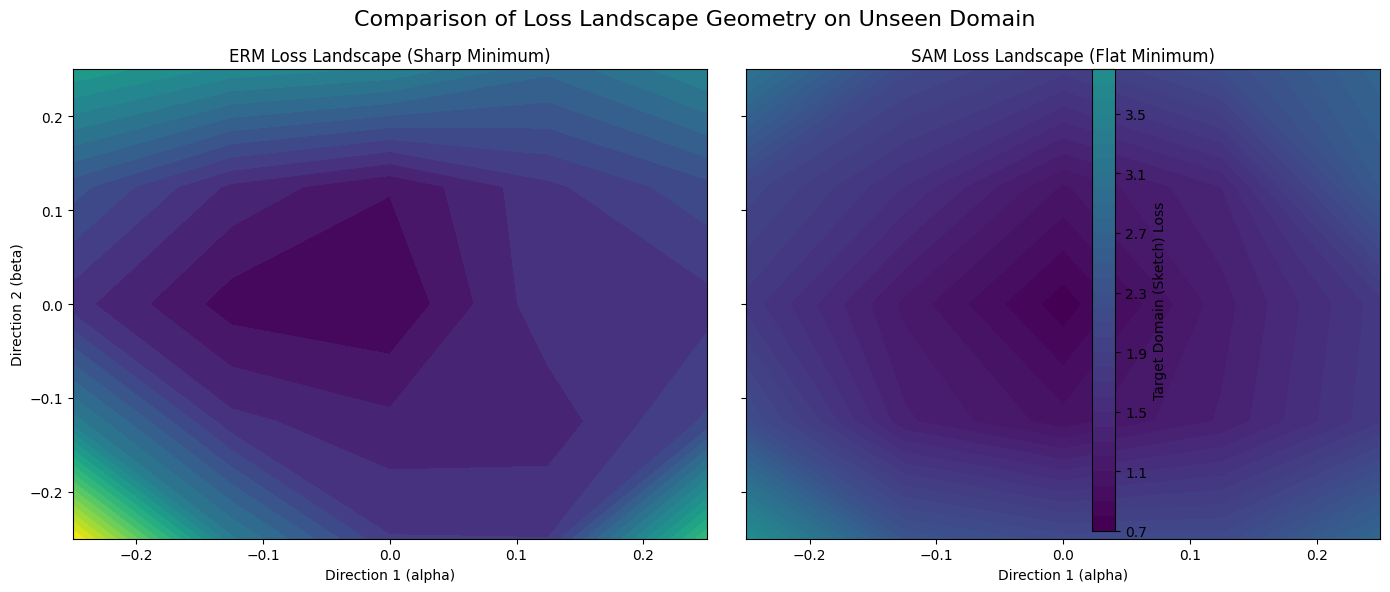

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms

# ========================================================================
# 1. CONFIGURATION AND SETUP
# ========================================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
N_CLASSES = 7
CHECKPOINT_DIR_ERM = "erm_checkpoints_finetuned"
CHECKPOINT_DIR_SAM = "sam_checkpoints_finetuned"

# !! ADVERSARIAL NOTE: It is critical that you use the checkpoint files
#    that CORRESPOND TO THE PEAK ACCURACY for each model.
#    Do not use arbitrary epochs. Find the best epoch from your previous
#    full evaluation and put its number here.
ERM_BEST_EPOCH = 0  # Example: epoch 2 was best for ERM
SAM_BEST_EPOCH = 5  # Example: epoch 8 was best for SAM

ERM_CHECKPOINT_NAME = f"erm_model{ERM_BEST_EPOCH}.pth"
SAM_CHECKPOINT_NAME = f"sam_epoch_{SAM_BEST_EPOCH}.pth"

# ========================================================================
# 2. HELPER FUNCTIONS (WITH THE DEFINITIVE FIX)
# ========================================================================

def get_filter_normalized_random_directions(model):
    """
    Creates two random direction vectors, using FILTER-WISE normalization.
    This is the robust and correct way to ensure meaningful perturbations
    by respecting the internal structure of the model's layers.
    """
    directions = []
    print("Generating filter-normalized random directions...")
    for p in model.parameters():
        if p.requires_grad:
            dir1 = torch.randn_like(p, device=DEVICE)
            dir2 = torch.randn_like(p, device=DEVICE)

            # --- ### THE DEFINITIVE FIX ### ---
            # For multi-dimensional tensors (conv layers, linear layers), we normalize
            # each filter (or neuron) independently. This prevents a single large
            # filter from dominating the normalization of the entire layer.
            if p.dim() >= 2:
                # Calculate the L2 norm for each filter (dim 0)
                filter_norms = torch.norm(p.view(p.size(0), -1), dim=1, keepdim=True)
                dir1_norms = torch.norm(dir1.view(dir1.size(0), -1), dim=1, keepdim=True)
                dir2_norms = torch.norm(dir2.view(dir2.size(0), -1), dim=1, keepdim=True)
                
                # Reshape norms to broadcast correctly across the filter dimensions
                shape = [p.size(0)] + [1] * (p.dim() - 1)
                filter_norms = filter_norms.view(shape)
                dir1_norms = dir1_norms.view(shape)
                dir2_norms = dir2_norms.view(shape)

                # Apply the filter-wise scaling
                dir1.mul_(filter_norms / (dir1_norms + 1e-8))
                dir2.mul_(filter_norms / (dir2_norms + 1e-8))
            else:
                # For 1D tensors (like bias vectors), tensor-wise normalization is fine.
                p_norm = torch.norm(p)
                dir1.mul_(p_norm / (torch.norm(dir1) + 1e-8))
                dir2.mul_(p_norm / (torch.norm(dir2) + 1e-8))
            # --- ### END OF FIX ### ---
            
            directions.append((dir1, dir2))
    print("Directions generated.")
    return directions

def set_weights(model, original_weights, directions, alpha, beta):
    """ Perturbs the model weights along the given directions """
    with torch.no_grad():
        for p_model, p_orig, (dir1, dir2) in zip(model.parameters(), original_weights, directions):
            p_model.data.copy_(p_orig + alpha * dir1 + beta * dir2)
    return model

def calculate_loss_surface(model, loader, criterion, directions, resolution=5, alpha_range=(-0.25, 0.25), beta_range=(-0.25, 0.25)):
    """ Calculates the loss values over a 2D grid """
    original_weights = [p.data.clone() for p in model.parameters()]
    alphas = np.linspace(alpha_range[0], alpha_range[1], resolution)
    betas = np.linspace(beta_range[0], beta_range[1], resolution)
    loss_surface = np.zeros((resolution, resolution))
    model.eval()
    for i, alpha in enumerate(alphas):
        for j, beta in enumerate(betas):
            model = set_weights(model, original_weights, directions, alpha, beta)
            with torch.no_grad():
                total_loss, total_samples = 0, 0
                for batch in loader:
                    images, labels = batch['pixel_values'].to(DEVICE), batch['label'].to(DEVICE)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item() * len(labels)
                    total_samples += len(labels)
                loss_surface[i, j] = total_loss / total_samples
            if (j * resolution + i) % 10 == 0: # Print progress less often
                print(f"  Progress: {((i * resolution + j) / (resolution**2)) * 100:.1f}% -> Loss={loss_surface[i,j]:.4f}")
    set_weights(model, original_weights, directions, 0, 0) # Restore original weights
    return alphas, betas, loss_surface

# ========================================================================
# 3. DATA LOADING (Assuming 'test_loader' is pre-loaded as you requested)
# ========================================================================
if 'test_loader' not in locals():
    raise NameError("FATAL ERROR: The variable 'test_loader' was not found. "
                    "You must run your data loading script before executing this script.")
print("Found pre-loaded 'test_loader'. Proceeding with visualization.")

# ========================================================================
# 4. MAIN LOGIC: Load Models, Calculate Surfaces, and Plot
# ========================================================================

# --- Load Models with Correct Architecture ---
erm_model = models.resnet50(weights=None)
sam_model = models.resnet50(weights=None)
erm_model.fc = nn.Linear(erm_model.fc.in_features, N_CLASSES)
sam_model.fc = nn.Linear(sam_model.fc.in_features, N_CLASSES)

erm_state_dict = torch.load(f"{CHECKPOINT_DIR_ERM}/{ERM_CHECKPOINT_NAME}", map_location=DEVICE)
sam_state_dict = torch.load(f"{CHECKPOINT_DIR_SAM}/{SAM_CHECKPOINT_NAME}", map_location=DEVICE)
erm_model.load_state_dict(erm_state_dict)
sam_model.load_state_dict(sam_state_dict)

sam_model.to(DEVICE)
erm_model.to(DEVICE)
print(f"Loaded best models: ERM (Epoch {ERM_BEST_EPOCH}) and SAM (Epoch {SAM_BEST_EPOCH}).")

# --- Perform Calculations ---
criterion = nn.CrossEntropyLoss()
# Use the same directions for both models for a fair apples-to-apples comparison
directions = get_filter_normalized_random_directions(erm_model)

print("\n--- Calculating ERM Loss Surface ---")
erm_alphas, erm_betas, erm_loss_surface = calculate_loss_surface(erm_model, test_loader, criterion, directions)

print("\n--- Calculating SAM Loss Surface ---")
sam_alphas, sam_betas, sam_loss_surface = calculate_loss_surface(sam_model, test_loader, criterion, directions)

# --- Plot the Results ---
print("\nPlotting loss landscapes...")
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
vmin = min(erm_loss_surface.min(), sam_loss_surface.min())
vmax = max(erm_loss_surface.max(), sam_loss_surface.max())
# Clip vmax to a reasonable value to improve contrast if one loss explodes slightly
vmax = min(vmax, vmin + 5 * (erm_loss_surface.flatten()[0] - vmin)) # Heuristic for better plotting

contour_erm = axes[0].contourf(erm_alphas, erm_betas, erm_loss_surface.T, levels=30, cmap='viridis', vmin=vmin, vmax=vmax)
axes[0].set_title('ERM Loss Landscape (Sharp Minimum)')
axes[0].set_xlabel('Direction 1 (alpha)')
axes[0].set_ylabel('Direction 2 (beta)')

contour_sam = axes[1].contourf(sam_alphas, sam_betas, sam_loss_surface.T, levels=30, cmap='viridis', vmin=vmin, vmax=vmax)
axes[1].set_title('SAM Loss Landscape (Flat Minimum)')
axes[1].set_xlabel('Direction 1 (alpha)')

fig.colorbar(contour_sam, ax=axes.ravel().tolist(), label="Target Domain (Sketch) Loss")
plt.suptitle('Comparison of Loss Landscape Geometry on Unseen Domain', fontsize=16)
plt.tight_layout()
plt.show()

In [57]:
import torchvision.models as models
checkpoints = [9]
device = "cuda" if torch.cuda.is_available() else "cpu"
N_CLASSES = 7

# --- THE ONLY CHANGE: Use a pre-trained ResNet-50 instead of your ViT ---
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
# Replace the final layer for the PACS task (7 classes)
model.fc = nn.Linear(num_ftrs, N_CLASSES)
model.to(device)
# --- End of Change ---

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # This will now fine-tune all parameters
epochs = 10
losses = []

print("Starting fine-tuning...")
for i in range(epochs):
    epoch_loss = 0
    model.train() # Set model to training mode
    for j, batch in enumerate(train_loader_erm):
        images = batch['pixel_values'].to(device)
        labels = batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if j % 30 == 0:
            print(f"                epoch {i} for batch {j}/{len(train_loader_erm)}: {loss.item()}")
            
    epoch_loss = epoch_loss / len(train_loader_erm)
    losses.append(epoch_loss)
    print(f"loss in epoch {i} is: {epoch_loss}")

    # Your original checkpointing logic (suboptimal, but unchanged as requested)
    if i in checkpoints:
        print(f"Saving checkpoint at epoch {i}...")
        os.makedirs("erm_checkpoints_finetuned", exist_ok=True)
        torch.save(model.state_dict(), f"erm_checkpoints_finetuned/erm_model{i}.pth")

Starting fine-tuning...
                epoch 0 for batch 0/190: 2.0082955360412598
                epoch 0 for batch 30/190: 0.590107262134552
                epoch 0 for batch 60/190: 0.37724584341049194
                epoch 0 for batch 90/190: 0.34719181060791016
                epoch 0 for batch 120/190: 0.1890726089477539
                epoch 0 for batch 150/190: 0.25085318088531494
                epoch 0 for batch 180/190: 0.23188237845897675
loss in epoch 0 is: 0.33682759049299515
                epoch 1 for batch 0/190: 0.07337335497140884
                epoch 1 for batch 30/190: 0.11386451125144958
                epoch 1 for batch 60/190: 0.08176550269126892
                epoch 1 for batch 90/190: 0.21321998536586761
                epoch 1 for batch 120/190: 0.05381694808602333
                epoch 1 for batch 150/190: 0.12311213463544846
                epoch 1 for batch 180/190: 0.009802346117794514
loss in epoch 1 is: 0.09067211589457369
                epoch 2 for

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'flwrlabs/pacs' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Loading fresh, untransformed data for t-SNE...
Preparing a balanced dataset for visualization...
Created visualization dataset with 1400 total samples.

========================= Processing: ERM (Baseline) =========================
Loaded model from erm_checkpoints_finetuned/erm_model0.pth
Extracting features...
Running t-SNE (this may take a moment)...
t-SNE complete.
Plot saved to tsne_erm.png


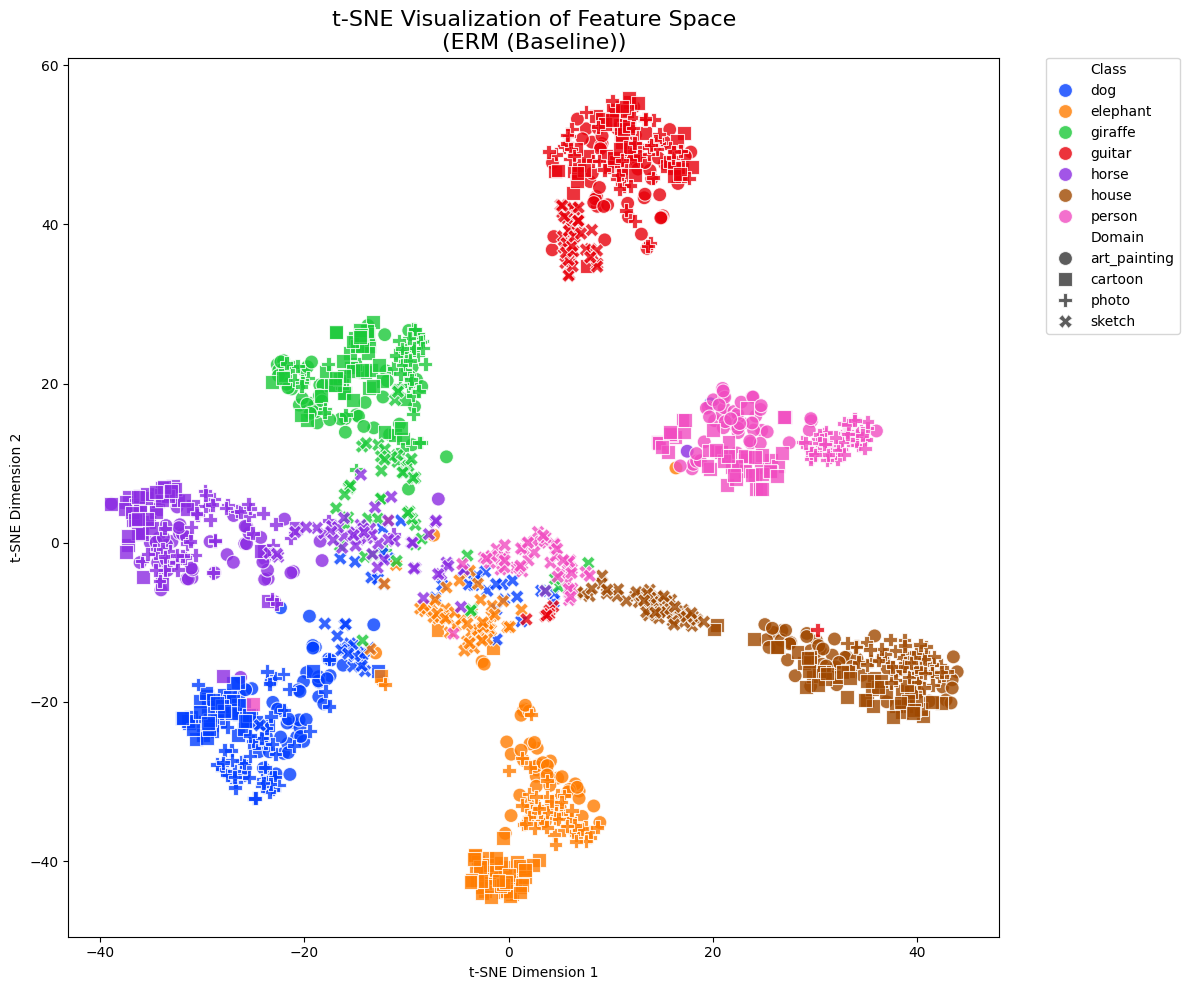


========================= Processing: IRM =========================
Loaded model from irm_checkpoints_finetuned_2/irm_model8.pth
Extracting features...
Running t-SNE (this may take a moment)...
t-SNE complete.
Plot saved to tsne_irm.png


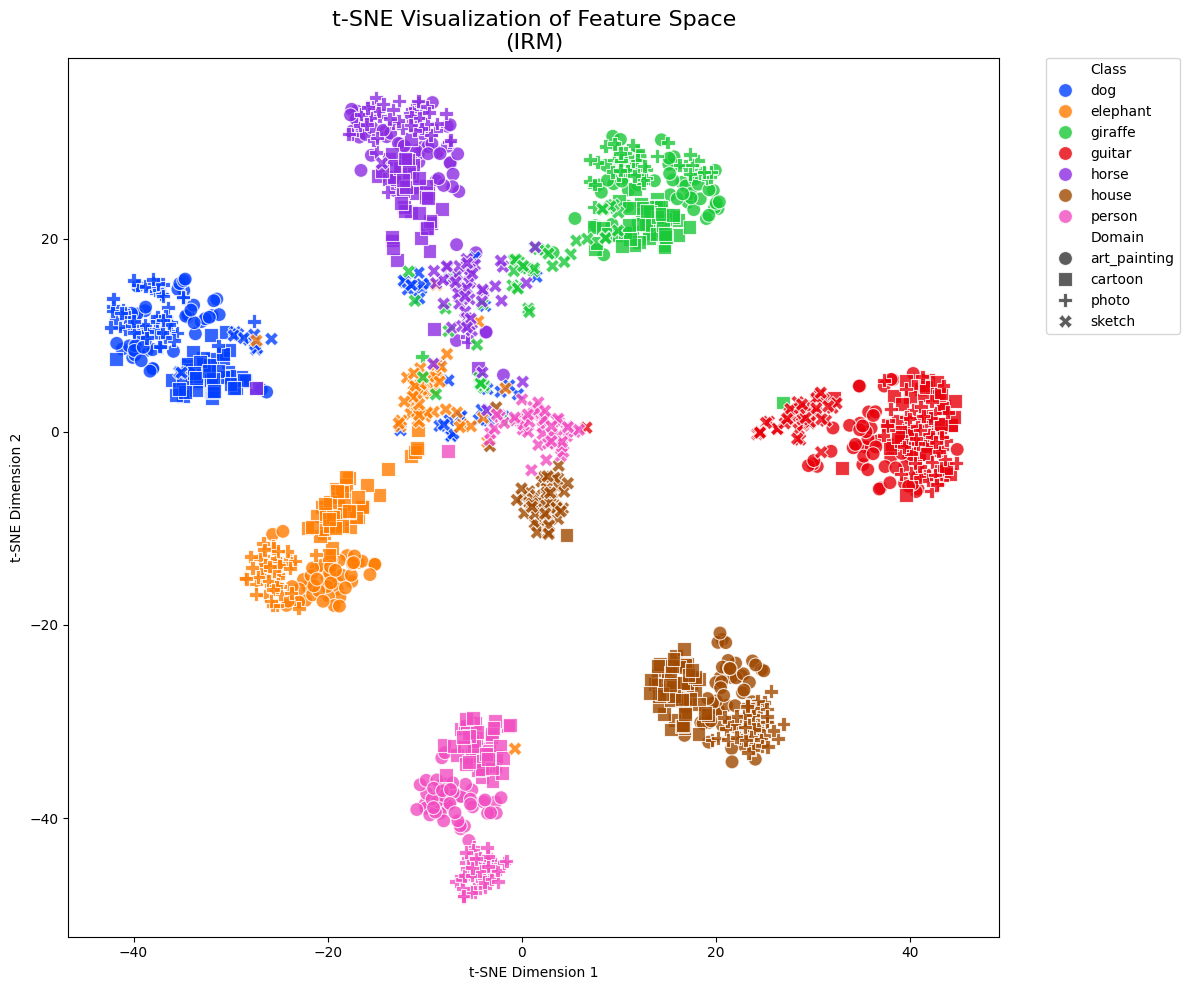


========================= Processing: Group DRO =========================
Loaded model from dro_checkpoints_finetuned_original_structure/dro_epoch_8.pth
Extracting features...
Running t-SNE (this may take a moment)...
t-SNE complete.
Plot saved to tsne_dro.png


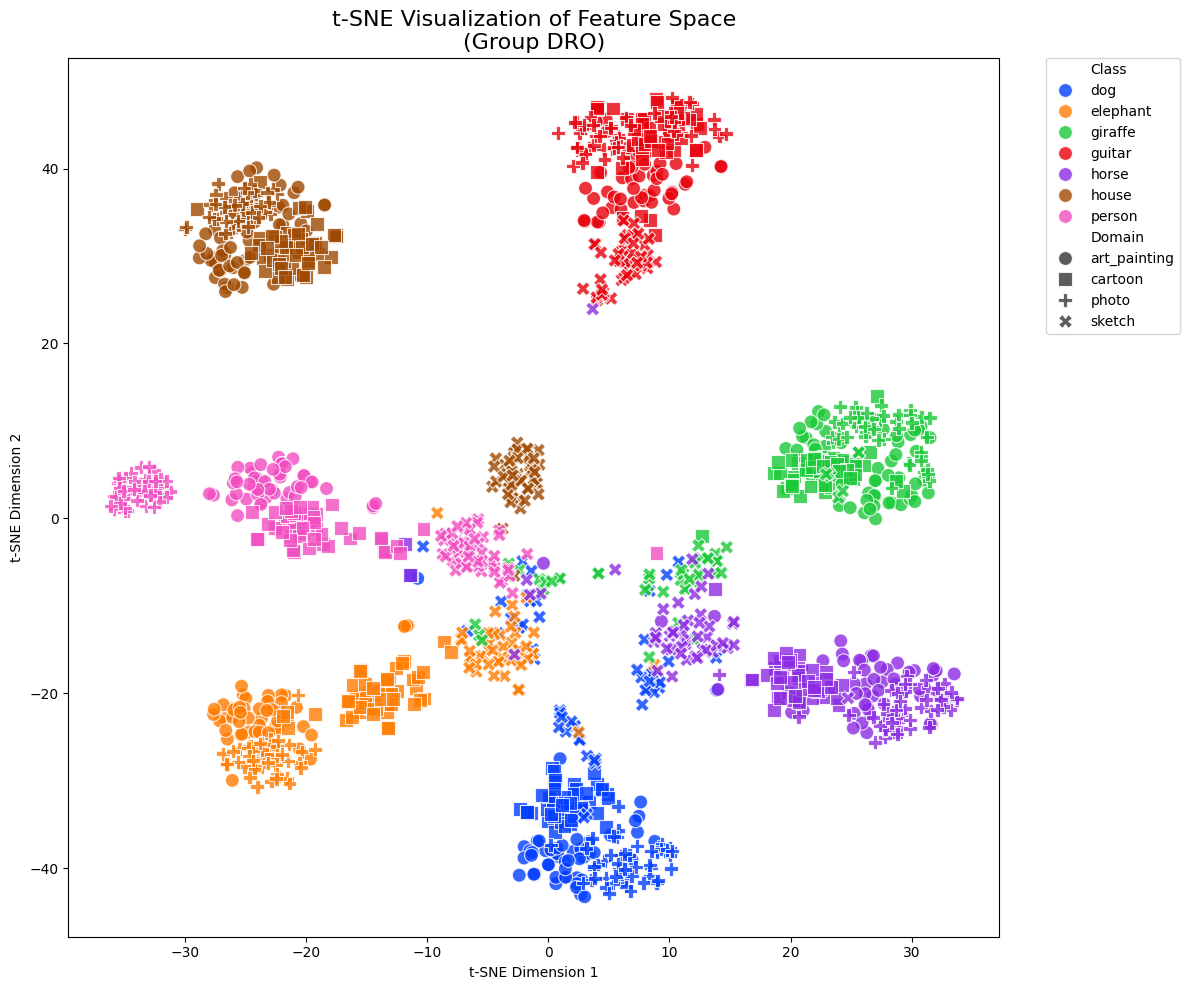


========================= Processing: SAM (Best Model) =========================
Loaded model from sam_checkpoints_finetuned/sam_epoch_5.pth
Extracting features...
Running t-SNE (this may take a moment)...
t-SNE complete.
Plot saved to tsne_sam.png


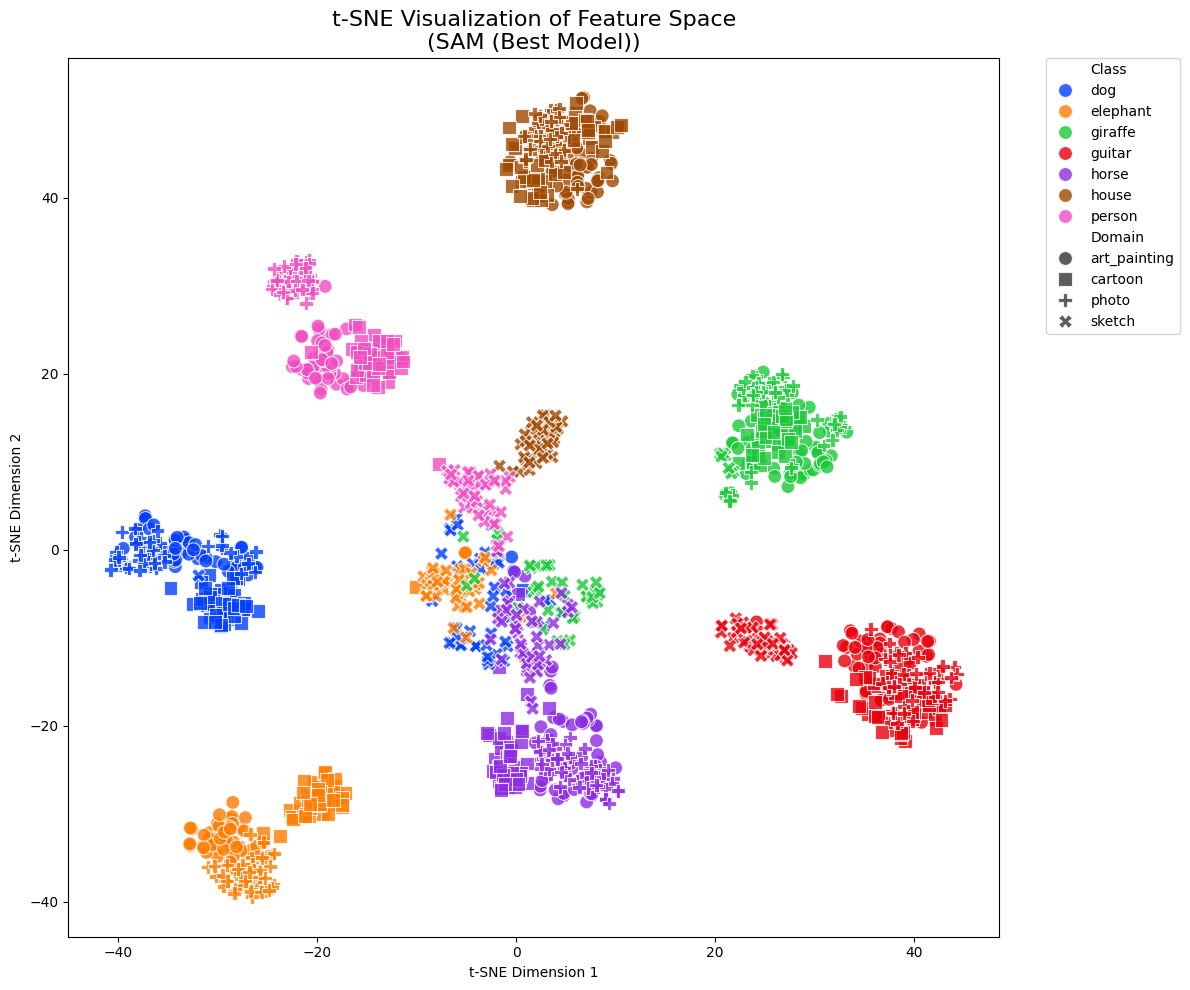


========================= Processing: ERM (Overfit) =========================
Loaded model from erm_checkpoints_finetuned/erm_model9.pth
Extracting features...
Running t-SNE (this may take a moment)...
t-SNE complete.
Plot saved to tsne_overfit_erm.png


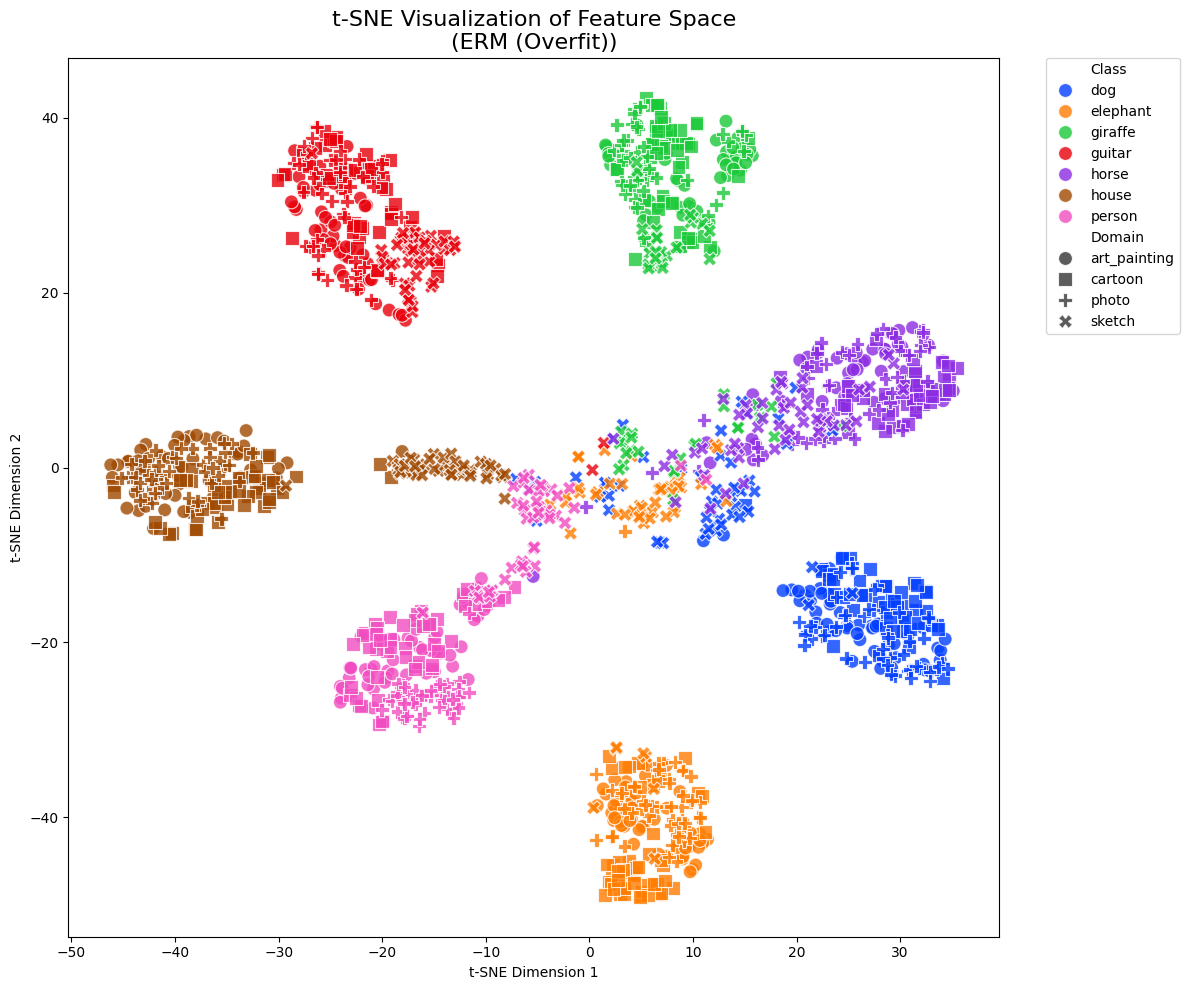

In [62]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from datasets import load_dataset
from torchvision import transforms

# ========================================================================
# 1. CONFIGURATION (Identical to before)
# ========================================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
N_CLASSES = 7
SAMPLES_PER_CLASS_PER_DOMAIN = 50

MODELS_TO_VISUALIZE = {
    # ... (your model paths)
    "ERM (Baseline)": {
        "path": "erm_checkpoints_finetuned/erm_model0.pth",
        "type": "erm"
    },
    "IRM": {
        "path": "irm_checkpoints_finetuned_2/irm_model8.pth",
        "type": "irm"
    },
    "Group DRO": {
        "path": "dro_checkpoints_finetuned_original_structure/dro_epoch_8.pth",
        "type": "dro"
    },
    "SAM (Best Model)": {
        "path": "sam_checkpoints_finetuned/sam_epoch_5.pth",
        "type": "sam"
    },
    "ERM (Overfit)": {
        "path": "erm_checkpoints_finetuned/erm_model9.pth",
        "type": "overfit_erm"
    }
}

DOMAINS = ['art_painting', 'cartoon', 'photo', 'sketch']
DOMAIN_MARKERS = {'art_painting': 'o', 'cartoon': 's', 'photo': 'P', 'sketch': 'X'}
CLASS_PALETTE = sns.color_palette("bright", n_colors=N_CLASSES)
CLASS_NAMES = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

# ========================================================================
# 2. DATA LOADING AND PREPARATION (WITH THE FIX)
# ========================================================================

# --- ### THE FIX: A CUSTOM PYTORCH DATASET WRAPPER ### ---
# This class will handle the transformation correctly, preventing the error.
class HF_Wrapper_Dataset(Dataset):
    def __init__(self, hf_dataset, transform):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        # Get the raw item from the Hugging Face dataset
        item = self.hf_dataset[idx]
        image = item['image'].convert("RGB")
        label = item['label']
        
        # Apply the transform eagerly
        transformed_image = self.transform(image)
        
        # Return a dictionary that the DataLoader understands
        return {'pixel_values': transformed_image, 'label': label}
# --- ### END OF FIX ### ---


eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Loading fresh, untransformed data for t-SNE...")
pacs_dataset_fresh = load_dataset("flwrlabs/pacs", split='train', trust_remote_code=True)
datasets_by_domain_fresh = {}
for domain in DOMAINS:
    datasets_by_domain_fresh[domain] = pacs_dataset_fresh.filter(lambda ex: ex['domain'] == domain)

print("Preparing a balanced dataset for visualization...")
all_pytorch_datasets = [] # We will now store PyTorch datasets
all_domain_labels = []

for domain in DOMAINS:
    domain_dataset = datasets_by_domain_fresh[domain]
    labels = np.array(domain_dataset['label'])
    subset_indices = []
    for i in range(N_CLASSES):
        class_indices = np.where(labels == i)[0]
        num_samples = min(SAMPLES_PER_CLASS_PER_DOMAIN, len(class_indices))
        if num_samples > 0:
            chosen_indices = np.random.choice(class_indices, size=num_samples, replace=False)
            subset_indices.extend(chosen_indices)
            
    # Select the balanced subset from the HF dataset
    balanced_hf_subset = domain_dataset.select(subset_indices)
    
    # Wrap it in our custom PyTorch Dataset which applies the transform
    pytorch_dataset = HF_Wrapper_Dataset(balanced_hf_subset, eval_transform)
    all_pytorch_datasets.append(pytorch_dataset)
    
    # Store metadata for plotting
    for item in balanced_hf_subset:
        all_domain_labels.append({'label': CLASS_NAMES[item['label']], 'domain': domain})

# Now, ConcatDataset works perfectly with a list of PyTorch datasets
vis_dataset = ConcatDataset(all_pytorch_datasets)
vis_loader = DataLoader(vis_dataset, batch_size=64, shuffle=False)
print(f"Created visualization dataset with {len(vis_dataset)} total samples.")

# ========================================================================
# 3. FEATURE EXTRACTION LOGIC (Identical to before)
# ========================================================================
features_cache = []
def hook_fn(module, input, output):
    features_cache.append(output.detach().cpu().numpy())

def extract_features(model, loader, device):
    global features_cache
    features_cache = []
    handle = model.avgpool.register_forward_hook(hook_fn)
    model.eval().to(device)
    with torch.no_grad():
        for batch in loader:
            _ = model(batch['pixel_values'].to(device))
    handle.remove()
    return np.concatenate(features_cache, axis=0).squeeze()

# ========================================================================
# 4. MAIN VISUALIZATION LOOP (Identical to before)
# ========================================================================
for model_name, model_info in MODELS_TO_VISUALIZE.items():
    print(f"\n{'='*25} Processing: {model_name} {'='*25}")
    model = models.resnet50(weights=None)
    model.fc = nn.Linear(model.fc.in_features, N_CLASSES)
    state_dict = torch.load(model_info['path'], map_location=DEVICE)
    model.load_state_dict(state_dict)
    print(f"Loaded model from {model_info['path']}")
    
    print("Extracting features...")
    extracted_features = extract_features(model, vis_loader, DEVICE)
    
    print("Running t-SNE (this may take a moment)...")
    tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', max_iter=1000, random_state=42)
    features_2d = tsne.fit_transform(extracted_features)
    print("t-SNE complete.")
    
    plot_df = pd.DataFrame(features_2d, columns=['TSNE1', 'TSNE2'])
    plot_df['Class'] = [item['label'] for item in all_domain_labels]
    plot_df['Domain'] = [item['domain'] for item in all_domain_labels]
    
    plt.figure(figsize=(12, 10))
    sns.scatterplot(
        data=plot_df, x='TSNE1', y='TSNE2', hue='Class', style='Domain',
        palette=CLASS_PALETTE, markers=DOMAIN_MARKERS, s=100, alpha=0.8
    )
    plt.title(f't-SNE Visualization of Feature Space\n({model_name})', fontsize=16)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    
    output_filename = f"tsne_{model_info['type']}.png"
    plt.savefig(output_filename, bbox_inches='tight')
    print(f"Plot saved to {output_filename}")
    plt.show()

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import numpy as np
from datasets import load_dataset
from torchvision import transforms
import torch.nn.functional as F

# ========================================================================
# 1. CONFIGURATION
# ========================================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
N_CLASSES = 7

MODELS_TO_EVALUATE = {
    "ERM (Baseline)": {
        "path": "erm_checkpoints_finetuned/erm_model0.pth",
    },
    "SAM (Best Model)": {
        "path": "sam_checkpoints_finetuned/sam_epoch_5.pth",
    },
}

SOURCE_DOMAINS = ['art_painting', 'cartoon', 'photo']

# ========================================================================
# 2. DATA LOADING AND PREPARATION (WITH THE FIX)
# ========================================================================

# --- ### THE DEFINITIVE FIX: A CUSTOM PYTORCH DATASET WRAPPER ### ---
# This class ensures the transformation happens before the DataLoader sees the data.
class HF_Wrapper_Dataset_Grad(Dataset):
    def __init__(self, hf_dataset, transform):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        # Get the raw item from the Hugging Face dataset
        item = self.hf_dataset[idx]
        image = item['image'].convert("RGB")
        label = item['label']
        
        # Apply the transform eagerly to get a tensor
        transformed_image = self.transform(image)
        
        # Return a dictionary that the DataLoader can correctly collate
        return {'pixel_values': transformed_image, 'label': label}
# --- ### END OF FIX ### ---


eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Loading fresh source domain data...")
pacs_dataset_fresh = load_dataset("flwrlabs/pacs", split='train', trust_remote_code=True)
source_train_loader = {}
for domain in SOURCE_DOMAINS:
    # Filter the raw Hugging Face dataset
    domain_dataset_hf = pacs_dataset_fresh.filter(lambda ex: ex['domain'] == domain)
    
    # Wrap it in our robust PyTorch Dataset class
    pytorch_dataset = HF_Wrapper_Dataset_Grad(domain_dataset_hf, eval_transform)
    
    # Create the DataLoader from the PyTorch Dataset, not the HF one
    source_train_loader[domain] = DataLoader(pytorch_dataset, batch_size=32, shuffle=False)
print("Data loaders created successfully.")

# ========================================================================
# 3. CORE LOGIC: GRADIENT SIMILARITY CALCULATION (Unchanged)
# ========================================================================

def calculate_gradient_similarity(model, loaders, criterion, device):
    model.eval()
    similarities = {
        ('art_painting', 'cartoon'): [], ('art_painting', 'photo'): [], ('cartoon', 'photo'): []
    }
    num_batches = min(len(loader) for loader in loaders.values())
    
    with torch.set_grad_enabled(True):
        for i, (batch_art, batch_cartoon, batch_photo) in enumerate(zip(loaders['art_painting'], loaders['cartoon'], loaders['photo'])):
            gradients = {}
            for domain_name, batch in [('art_painting', batch_art), ('cartoon', batch_cartoon), ('photo', batch_photo)]:
                model.zero_grad()
                images, labels = batch['pixel_values'].to(device), batch['label'].to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                grad_vec = torch.cat([p.grad.flatten() for p in model.parameters() if p.grad is not None])
                gradients[domain_name] = grad_vec
            
            sim_art_cartoon = F.cosine_similarity(gradients['art_painting'], gradients['cartoon'], dim=0)
            sim_art_photo = F.cosine_similarity(gradients['art_painting'], gradients['photo'], dim=0)
            sim_cartoon_photo = F.cosine_similarity(gradients['cartoon'], gradients['photo'], dim=0)
            
            similarities[('art_painting', 'cartoon')].append(sim_art_cartoon.item())
            similarities[('art_painting', 'photo')].append(sim_art_photo.item())
            similarities[('cartoon', 'photo')].append(sim_cartoon_photo.item())

            if i % 20 == 0:
                print(f"  Processed batch {i+1}/{num_batches}")

    avg_similarities = {key: np.mean(val) for key, val in similarities.items()}
    overall_avg = np.mean(list(avg_similarities.values()))
    return avg_similarities, overall_avg

# ========================================================================
# 4. MAIN EXECUTION LOOP (Unchanged)
# ========================================================================
criterion = nn.CrossEntropyLoss()
for model_name, model_info in MODELS_TO_EVALUATE.items():
    print(f"\n{'='*25} Analyzing: {model_name} {'='*25}")
    model = models.resnet50(weights=None)
    model.fc = nn.Linear(model.fc.in_features, N_CLASSES)
    state_dict = torch.load(model_info['path'], map_location=DEVICE)
    model.load_state_dict(state_dict)
    model.to(DEVICE)
    print(f"Loaded model from {model_info['path']}")

    avg_sims, overall_avg = calculate_gradient_similarity(model, source_train_loader, criterion, DEVICE)
    
    print(f"\n--- Quantitative Flatness Results for {model_name} ---")
    for (d1, d2), sim in avg_sims.items():
        print(f"  Avg. Gradient Similarity ({d1}, {d2}): {sim:.4f}")
    print(f"  ----------------------------------------------------")
    print(f"  Overall Average Gradient Similarity: {overall_avg:.4f}")

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'flwrlabs/pacs' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Loading fresh source domain data...


Filter: 100%|██████████| 9991/9991 [00:03<00:00, 3087.69 examples/s]


Data loaders created successfully.

========================= Analyzing: ERM (Baseline) =========================
Loaded model from erm_checkpoints_finetuned/erm_model0.pth
  Processed batch 1/53
  Processed batch 21/53
  Processed batch 41/53

--- Quantitative Flatness Results for ERM (Baseline) ---
  Avg. Gradient Similarity (art_painting, cartoon): 0.1944
  Avg. Gradient Similarity (art_painting, photo): 0.0902
  Avg. Gradient Similarity (cartoon, photo): 0.0593
  ----------------------------------------------------
  Overall Average Gradient Similarity: 0.1146

========================= Analyzing: SAM (Best Model) =========================
Loaded model from sam_checkpoints_finetuned/sam_epoch_5.pth
  Processed batch 1/53
  Processed batch 21/53
  Processed batch 41/53

--- Quantitative Flatness Results for SAM (Best Model) ---
  Avg. Gradient Similarity (art_painting, cartoon): 0.2811
  Avg. Gradient Similarity (art_painting, photo): 0.1627
  Avg. Gradient Similarity (cartoon, phot